In [1]:
# https://www.kaggle.com/crowdflower/twitter-airline-sentiment
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

O arquivo “AirlineTweets.csv” já existe, não será baixado.



In [2]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
# ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')

# Diff
from typing import Dict

In [3]:
df_ = pd.read_csv("AirlineTweets.csv")

In [4]:
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
df = df_[['airline_sentiment', 'text']].copy()

In [6]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


<AxesSubplot: >

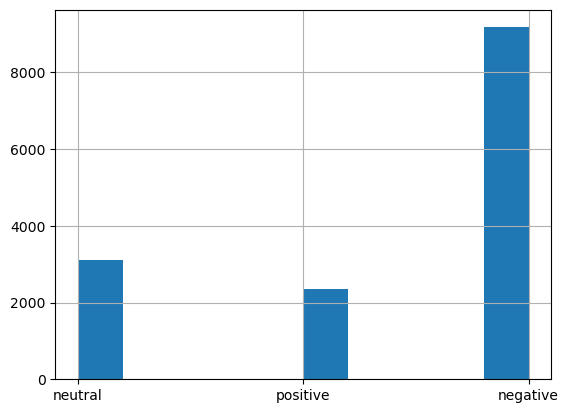

In [7]:
df['airline_sentiment'].hist()

In [8]:
target_map = {
    'positive': 1,
    'negative': 0,
    'neutral': 2,
}
df['target'] = df['airline_sentiment'].map(target_map)
df.head()

,airline_sentiment,text,target
0,neutral,@VirginAmerica What @dhepburn said.,2
1,positive,@VirginAmerica plus you've added commercials t...,1
2,neutral,@VirginAmerica I didn't today... Must mean I n...,2
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0


In [9]:
df2 = df[['text', 'target']]
# Not documented info: targets must have the column name label
# sentence may have other names, but not label
df2.columns = ['sentence', 'label']
df2.to_csv("data.csv", index=False)

In [10]:
!head data.csv

sentence,label
@VirginAmerica What @dhepburn said.,2
@VirginAmerica plus you've added commercials to the experience... tacky.,1
@VirginAmerica I didn't today... Must mean I need to take another trip!,2
"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
@VirginAmerica and it's a really big bad thing about it,0
"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA",0
"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",1
"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",2


In [11]:
from datasets import load_dataset
raw_dataset = load_dataset('csv', data_files='data.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [12]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [13]:
from datasets import Dataset, DatasetDict

def splitTrainTestValidation(dataset: Dataset, valid_size=.1, test_size=.1):
    len_valid = int(len(dataset) * valid_size)
    len_test = int(len(dataset) * test_size)
    
    splited: DatasetDict = dataset.train_test_split(len_valid + len_test, shuffle=False, seed=42)
    splited['validation'] = splited['test']
    del splited['test']
    
    splited_2 = splited['validation'].train_test_split(len_test, shuffle=True, seed=42)
    splited['validation'] = splited_2['train']
    splited['test'] = splited_2['test']
    
    return splited

In [14]:
# split = raw_dataset['train'].train_test_split(test_size=.3, seed=42)
split = splitTrainTestValidation(raw_dataset['train'], valid_size=.15, test_size=.15)

In [15]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    validation: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2196
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2196
    })
})

In [16]:
# if you have multiple csv files:
# load_dataset('csv', data_files=['file1.csv', 'file2.csv', ...])

In [17]:
# if you already have a train-test split:
# load_dataset(
#     "csv", data_files={"train": ["train1.csv", "train2.csv"], "test": "test.csv"}
# )


In [18]:
checkpoint = 'distilbert-base-cased'


In [19]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [20]:
def tokenize_fn(batch):
  return tokenizer(batch['sentence'], truncation=True)

In [21]:
tokenized_datasets = split.map(tokenize_fn, batched=True)

Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/2196 [00:00<?, ? examples/s]

Map:   0%|          | 0/2196 [00:00<?, ? examples/s]

In [22]:
print(tokenized_datasets['train'][0])

{'sentence': '@VirginAmerica What @dhepburn said.', 'label': 2, 'input_ids': [101, 137, 6567, 1592, 4027, 4578, 1327, 137, 173, 4638, 1643, 6715, 1163, 119, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [23]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 10248
    })
    validation: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2196
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2196
    })
})

In [24]:
# The difference from notebook Fine-Tunning Sentiment Custom Dataset starts here
# with the AutoConfig import
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoConfig 

In [25]:
config = AutoConfig.from_pretrained(checkpoint)

In [26]:
config

DistilBertConfig {
  "_name_or_path": "distilbert-base-cased",
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.31.0",
  "vocab_size": 28996
}

In [27]:
# diff (new cell)
config.id2label

{0: 'LABEL_0', 1: 'LABEL_1'}

In [28]:
# diff (new cell)
config.label2id

{'LABEL_0': 0, 'LABEL_1': 1}

In [29]:
# diff (new cell)
config.id2label = {v:k for k, v in target_map.items()}
config.label2id = target_map

In [30]:
# diff (new cell)
config.id2label

{1: 'positive', 0: 'negative', 2: 'neutral'}

In [31]:
# diff (new cell)
config.label2id

{'positive': 1, 'negative': 0, 'neutral': 2}

In [32]:
# Diff (add config to from_pretrained method)
# Diff (must exclude num_labels argument, since will be infered by the config parameters)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
!pip install torchinfo

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [34]:
from torchinfo import summary

In [35]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 65,783,811
Trainable params: 65,783,811
Non-trainable params: 0

In [36]:
training_args = TrainingArguments(
    output_dir="training_dir",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    seed=42,
)


In [37]:
def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels
    predictions = np.argmax(logits, axis=-1)
    acc = np.mean(predictions == labels)
    f1 = f1_score(labels, predictions, average="macro")
    return {"accuracy": acc, "f1": f1}


In [38]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [39]:
# Getting results before fine-tunning models
trainer.evaluate(eval_dataset=tokenized_datasets["test"])

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/35 [00:00<?, ?it/s]

{'eval_loss': 0.9995312690734863,
 'eval_accuracy': 0.732695810564663,
 'eval_f1': 0.28190976784932104,
 'eval_runtime': 3.0013,
 'eval_samples_per_second': 731.688,
 'eval_steps_per_second': 11.662}

In [40]:
trainer.train()

/home/bruno/anaconda3/envs/gpt/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1923 [00:00<?, ?it/s]

{'loss': 0.582, 'learning_rate': 3.699947997919917e-05, 'epoch': 0.78}


  0%|          | 0/35 [00:00<?, ?it/s]

{'eval_loss': 0.37795743346214294, 'eval_accuracy': 0.8652094717668488, 'eval_f1': 0.7729092896600122, 'eval_runtime': 2.1484, 'eval_samples_per_second': 1022.159, 'eval_steps_per_second': 16.291, 'epoch': 1.0}
{'loss': 0.379, 'learning_rate': 2.399895995839834e-05, 'epoch': 1.56}


  0%|          | 0/35 [00:00<?, ?it/s]

{'eval_loss': 0.3852788507938385, 'eval_accuracy': 0.8679417122040073, 'eval_f1': 0.772443126168147, 'eval_runtime': 2.1665, 'eval_samples_per_second': 1013.629, 'eval_steps_per_second': 16.155, 'epoch': 2.0}
{'loss': 0.253, 'learning_rate': 1.0998439937597505e-05, 'epoch': 2.34}


  0%|          | 0/35 [00:00<?, ?it/s]

{'eval_loss': 0.5092880129814148, 'eval_accuracy': 0.8574681238615665, 'eval_f1': 0.7748999478950092, 'eval_runtime': 2.0337, 'eval_samples_per_second': 1079.815, 'eval_steps_per_second': 17.21, 'epoch': 3.0}
{'train_runtime': 137.6705, 'train_samples_per_second': 223.316, 'train_steps_per_second': 13.968, 'train_loss': 0.35736973088542684, 'epoch': 3.0}


TrainOutput(global_step=1923, training_loss=0.35736973088542684, metrics={'train_runtime': 137.6705, 'train_samples_per_second': 223.316, 'train_steps_per_second': 13.968, 'train_loss': 0.35736973088542684, 'epoch': 3.0})

In [41]:
!ls training_dir

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
checkpoint-1282  checkpoint-1923  checkpoint-641


In [42]:
import copy

def evalCheckpoints(ckpt_path, checkpoints, trainer: Trainer, tokenized_datasets):
    columns = ["eval_accuracy", "eval_f1", "eval_loss"]
    results = pd.DataFrame(columns=columns, index=checkpoints)

    _device = trainer.model.device
    _config = trainer.model.config
    model = copy.deepcopy(trainer.model)

    for _ckpt in checkpoints:
        _model = AutoModelForSequenceClassification.from_pretrained(
            ckpt_path + "/" + _ckpt, config=_config
        )
        trainer.model = _model.to(_device)
        trainer.eval_dataset = tokenized_datasets["test"]
        result = {k: v for k, v in trainer.evaluate().items() if k in columns}
        results.loc[_ckpt] = result

    # Restore trainer
    trainer.model = model
    trainer.eval_dataset = tokenized_datasets["validation"]

    results.reset_index(inplace=True)
    results.rename(columns={"index": "checkpoint"}, inplace=True)
    print(results)

    # Create a 1x2 subplot layout
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot the evaluation results for accuracy and F1 score
    sn.lineplot(
        x="checkpoint",
        y="eval_accuracy",
        data=results,
        label="Accuracy Score",
        ax=axes[0],
    )
    sn.lineplot(x="checkpoint", y="eval_f1", data=results, label="F1 Score", ax=axes[0])
    axes[0].set_title("Evaluation Metrics")

    # Plot the evaluation results for loss
    sn.lineplot(x="checkpoint", y="eval_loss", data=results, ax=axes[1])
    axes[1].set_title("Evaluation Loss")

    # Adjust layout spacing
    plt.tight_layout()

    plt.show()


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

        checkpoint eval_accuracy   eval_f1 eval_loss
0   checkpoint-641      0.863388  0.770885  0.375166
1  checkpoint-1282      0.867031   0.77381  0.392206
2  checkpoint-1923       0.85929  0.774221  0.523352


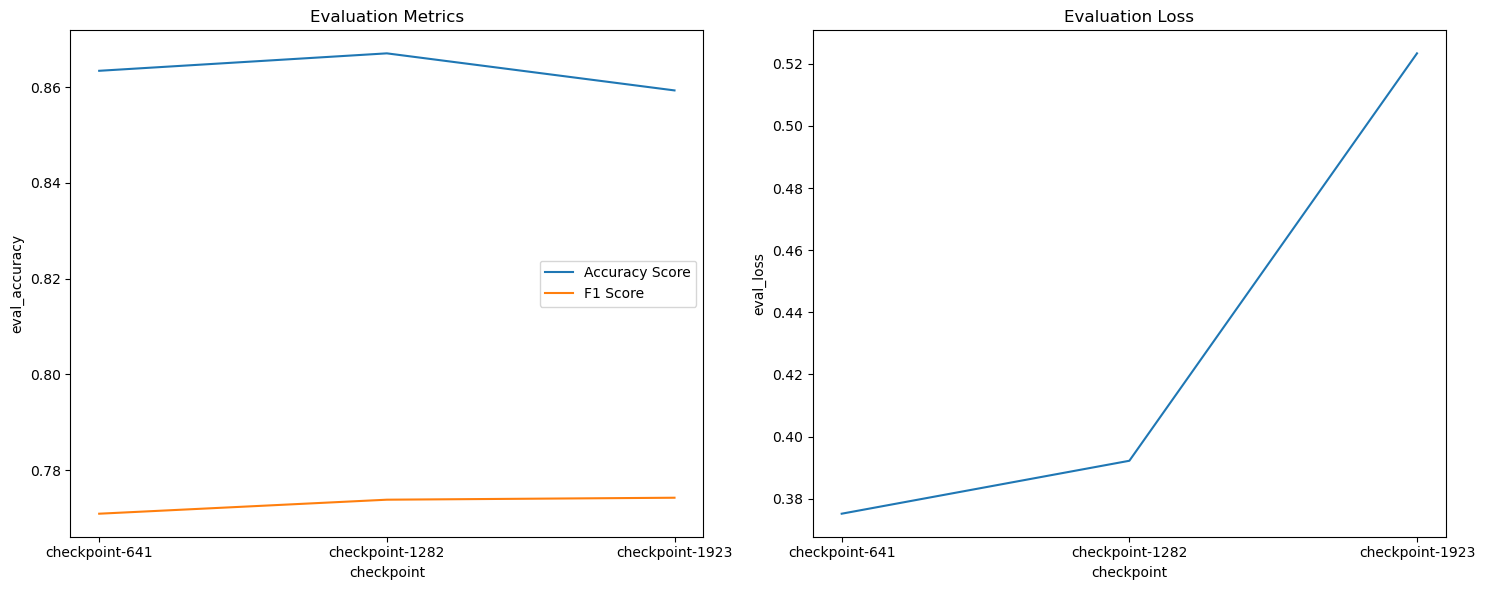

In [43]:
evalCheckpoints(
    "training_dir",
    ["checkpoint-641", "checkpoint-1282", "checkpoint-1923"],
    trainer=trainer,
    tokenized_datasets=tokenized_datasets,
)


In [44]:
from transformers import pipeline

In [45]:
savedmodel = pipeline('text-classification', model='training_dir/checkpoint-1282', device=0)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [46]:
split['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 2196
})

In [47]:
test_pred = savedmodel(split['test']['sentence'])

In [48]:
test_pred[:10]

[{'label': 'negative', 'score': 0.991866409778595},
 {'label': 'neutral', 'score': 0.4408416450023651},
 {'label': 'negative', 'score': 0.7575242519378662},
 {'label': 'negative', 'score': 0.9947192668914795},
 {'label': 'negative', 'score': 0.9955524802207947},
 {'label': 'negative', 'score': 0.99289470911026},
 {'label': 'negative', 'score': 0.9706099629402161},
 {'label': 'negative', 'score': 0.9738674759864807},
 {'label': 'negative', 'score': 0.9948305487632751},
 {'label': 'negative', 'score': 0.993631899356842}]

In [49]:
# Diff: labels are correct. we only need to get the integer index
# Labels are already correct
def getLabel(d, id2label: Dict):
    # Diff here
    return int(id2label[d['label']])

test_pred = [getLabel(d, target_map) for d in test_pred]
test_pred[:10]

[0, 2, 0, 0, 0, 0, 0, 0, 0, 0]

In [50]:
print(split['test']['label'])

[0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 1, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 2, 0, 0, 0, 1, 0, 2, 1, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 1, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 1, 0, 0, 0, 2, 2, 2, 0, 0, 2, 1, 0, 0, 2, 1, 0, 0, 0, 1, 2, 0, 0, 2, 0, 1, 2, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 

In [51]:
print(f"Accuracy: {accuracy_score(y_true=split['test']['label'], y_pred=test_pred)}")

Accuracy: 0.8670309653916212


In [52]:
print(f"f1: {f1_score(y_true=split['test']['label'], y_pred=test_pred, average='macro')}")

f1: 0.7738104433258798


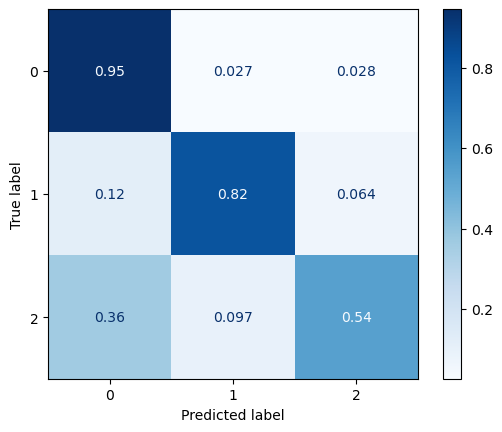

In [53]:
cm = confusion_matrix(y_true=split['test']['label'], y_pred=test_pred, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')

### Exercise: use binary classes and compare to pretrained pipeline from earlier

See the notebook:
Beginner's Corner/Pipeline Sentiment Analysis.ipynb
Let's compare the fine-tunned classifier with the raw sentiment-analisys pipeline 

In [54]:
df.head()


,airline_sentiment,text,target
0,neutral,@VirginAmerica What @dhepburn said.,2
1,positive,@VirginAmerica plus you've added commercials t...,1
2,neutral,@VirginAmerica I didn't today... Must mean I n...,2
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0


In [55]:
df_binary = df[df['airline_sentiment'] != 'neutral']
df_binary.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [56]:
df2 = df_binary[['text', 'target']]
df2.columns = ['sentence', 'label']
df2.to_csv("data_binary.csv", index=False)
df2.head()

,sentence,label
1,@VirginAmerica plus you've added commercials t...,1
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0
5,@VirginAmerica seriously would pay $30 a fligh...,0
6,"@VirginAmerica yes, nearly every time I fly VX...",1


In [57]:
!head data_binary.csv

sentence,label
@VirginAmerica plus you've added commercials to the experience... tacky.,1
"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
@VirginAmerica and it's a really big bad thing about it,0
"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA",0
"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",1
"@virginamerica Well, I didn't…but NOW I DO! :-D",1
"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.",1
@VirginAmerica I &lt;3 pretty graphics. so much better than minimal iconography. :D,1


In [58]:
raw_dataset_binary = load_dataset('csv', data_files="data_binary.csv")
raw_dataset_binary

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 11541
    })
})

In [59]:
# split_binary = raw_dataset_binary['train'].train_test_split(test_size=.3, seed=42)
split_binary = splitTrainTestValidation(raw_dataset_binary['train'], valid_size=.15, test_size=.15)
split_binary

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 8079
    })
    validation: Dataset({
        features: ['sentence', 'label'],
        num_rows: 1731
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 1731
    })
})

In [60]:
# Diff: new cell. Add new config
config_binary = AutoConfig.from_pretrained(checkpoint)
target_map_binary = {
    'positive': 1,
    'negative': 0
}
config_binary.id2label = {v: k for k, v in target_map_binary.items()}
config_binary.label2idx = target_map_binary

In [61]:
# Diff: new cell
config_binary.id2label 

{1: 'positive', 0: 'negative'}

In [62]:
# Diff: new cell
config_binary.label2idx

{'positive': 1, 'negative': 0}

In [63]:
# Diff: config instead of num_labels, as before
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config_binary)
model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [64]:
tokenized_datasets_binary = split_binary.map(tokenize_fn, batched=True)

Map:   0%|          | 0/8079 [00:00<?, ? examples/s]

Map:   0%|          | 0/1731 [00:00<?, ? examples/s]

Map:   0%|          | 0/1731 [00:00<?, ? examples/s]

In [65]:
tokenized_datasets_binary

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 8079
    })
    validation: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1731
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1731
    })
})

In [66]:
training_args_binary = TrainingArguments(
    "training_dir_binary",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    seed=42,
)

In [67]:
trainer_binary = Trainer(
    model,
    training_args_binary,
    train_dataset=tokenized_datasets_binary['train'],
    eval_dataset=tokenized_datasets_binary['validation'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

In [68]:
# Getting results before fine-tunning models
trainer_binary.evaluate(eval_dataset=tokenized_datasets_binary['test'])

  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.6459435820579529,
 'eval_accuracy': 0.8659734257654534,
 'eval_f1': 0.46408668730650154,
 'eval_runtime': 1.7578,
 'eval_samples_per_second': 984.75,
 'eval_steps_per_second': 15.929}

In [69]:
trainer_binary.train()

/home/bruno/anaconda3/envs/gpt/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1515 [00:00<?, ?it/s]

{'loss': 0.2364, 'learning_rate': 3.34983498349835e-05, 'epoch': 0.99}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.15175342559814453, 'eval_accuracy': 0.9451184286539572, 'eval_f1': 0.8864976791537971, 'eval_runtime': 1.9013, 'eval_samples_per_second': 910.423, 'eval_steps_per_second': 14.727, 'epoch': 1.0}
{'loss': 0.1094, 'learning_rate': 1.6996699669966998e-05, 'epoch': 1.98}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.16520242393016815, 'eval_accuracy': 0.9480069324090121, 'eval_f1': 0.8981658212623542, 'eval_runtime': 1.969, 'eval_samples_per_second': 879.144, 'eval_steps_per_second': 14.221, 'epoch': 2.0}
{'loss': 0.0342, 'learning_rate': 4.950495049504951e-07, 'epoch': 2.97}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.24535244703292847, 'eval_accuracy': 0.950895436164067, 'eval_f1': 0.9008164016445326, 'eval_runtime': 2.0171, 'eval_samples_per_second': 858.174, 'eval_steps_per_second': 13.882, 'epoch': 3.0}
{'train_runtime': 120.9322, 'train_samples_per_second': 200.418, 'train_steps_per_second': 12.528, 'train_loss': 0.12564981725349678, 'epoch': 3.0}


TrainOutput(global_step=1515, training_loss=0.12564981725349678, metrics={'train_runtime': 120.9322, 'train_samples_per_second': 200.418, 'train_steps_per_second': 12.528, 'train_loss': 0.12564981725349678, 'epoch': 3.0})

In [70]:
!ls training_dir_binary

checkpoint-1010  checkpoint-1515  checkpoint-505


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

        checkpoint eval_accuracy   eval_f1 eval_loss
0   checkpoint-505      0.958406   0.90699  0.124594
1  checkpoint-1010       0.94974    0.8931  0.153802
2  checkpoint-1515      0.954939  0.902584  0.221896


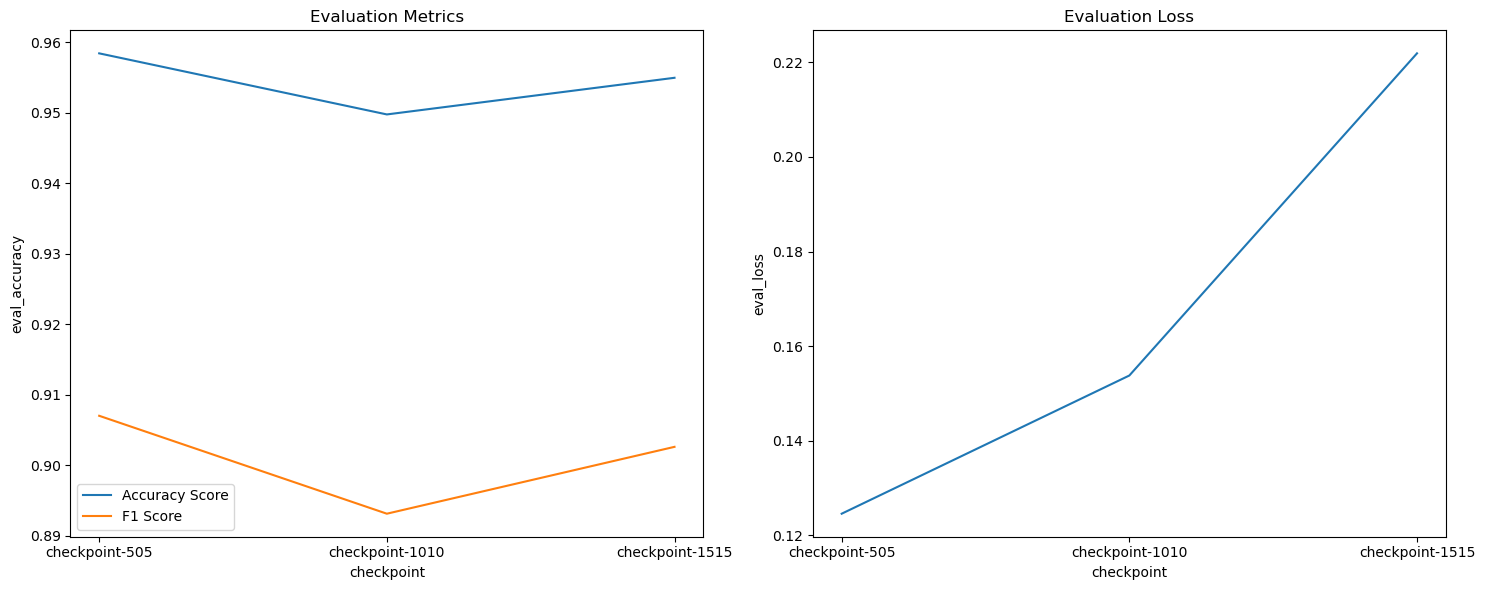

In [71]:
evalCheckpoints(
    "training_dir_binary",
    ['checkpoint-505', 'checkpoint-1010', 'checkpoint-1515'],
    trainer=trainer_binary,
    tokenized_datasets=tokenized_datasets_binary,
)


In [72]:
savedmodel_binary = pipeline('text-classification', model='training_dir_binary/checkpoint-505', device=0)

In [73]:
test_pred_binary = savedmodel_binary(split_binary['test']['sentence'])
test_pred_binary[:10]

[{'label': 'negative', 'score': 0.9968855977058411},
 {'label': 'negative', 'score': 0.9944515824317932},
 {'label': 'negative', 'score': 0.9961405396461487},
 {'label': 'negative', 'score': 0.7164847254753113},
 {'label': 'negative', 'score': 0.9859390258789062},
 {'label': 'negative', 'score': 0.995086133480072},
 {'label': 'negative', 'score': 0.9829860329627991},
 {'label': 'negative', 'score': 0.9973263740539551},
 {'label': 'positive', 'score': 0.9797900915145874},
 {'label': 'positive', 'score': 0.9407411813735962}]

In [74]:
test_pred_binary = [getLabel(d, target_map) for d in test_pred_binary]
test_pred_binary[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1]

In [75]:
print(split_binary['test']['label'])

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 

In [76]:
print(f"Accuracy: {accuracy_score(y_true=split_binary['test']['label'], y_pred=test_pred_binary)}")

Accuracy: 0.9584055459272097


In [77]:
print(f"f1: {f1_score(y_true=split_binary['test']['label'], y_pred=test_pred_binary, average='macro')}")

f1: 0.9069904894954597


#### Conclusão:

##### Classificador ternário (classes: POSITIVE, NEUTRAL e NEGATIVE)

Pré-treinado
- Loss: 0.9995312690734863
- Accuracy: 0.732695810564663
- F1: 0.28190976784932104


Após fine-tunning (checkpoint-1282)
- Loss: 0.392206
- Accuracy: 0.867031
- F1: 0.77381


##### Comparação entre modelo pré-treinado e fine-tunned (ternário):

Temos uma acurácia com Fine-Tunning de 0.867031, contra 0.732695810564663 no pré-treinado

Temos uma f1 com Fine-Tunning de 0.77381, contra 0.28190976784932104 no pré-treinado

Portanto, o fine tunning foi capaz de melhorar significativamente a performance em relação ao modelo pré-treinado (zero shot)


##### Classificador binário (classes: POSITIVE e NEGATIVE)

Pré-treinado
- Loss: 0.6459435820579529,
- Accuracy: 0.8659734257654534
- F1: 0.46408668730650154

Após fine-tunning (checkpoint-505)
- Loss: 0.124594
- Accuracy: 0.9584055459272097
- F1: 0.9069904894954597
            

##### Comparação entre modelo pré-treinado e fine-tunned (binário):

Temos uma acurácia com Fine-Tunning de 0.9584055459272097, contra 0.8659734257654534 no pré-treinado

Temos f1 com Fine-Tunning de 0.9069904894954597, contra 0.46408668730650154 no pré-treinado

Portanto, o fine tunning foi capaz de melhorar significativamente a performance em relação ao modelo pré-treinado (zero shot)

##### Comparação entre o modelo fine-tunned e o modelo de sentiment-analisys (binário):

Ver arquivo: Beginner's Corner/Pipeline Sentiment Analysis.ipynb

Modelo Sentiment Analysis:
- Accuracy: 0.8898708950697514
- F1: 0.7587777566900741

Temos uma acurácia com Fine-Tunning de 0.9584055459272097, contra 0.8898708950697514 no sentiment analysis

Temos f1 com Fine-Tunning de 0.9069904894954597, contra 0.7587777566900741 no sentiment analysis

Portanto, o fine tunning foi capaz de melhorar significativamente a performance em relação ao modelo pré-treinado para análise de sentimento